In [1]:
#Import necessary packages

import pandas as pd
import numpy as np
import matplotlib as mpl
from pvlive_api import PVLive
import pytz
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

import missingno as missingno

%matplotlib inline

import statsmodels.tsa.api as tsa
import statsmodels
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

import pmdarima as pmd

import json


from sklearn.ensemble import RandomForestRegressor
from sktime.forecasting.all import *
from sktime.forecasting.compose import *
from sktime.forecasting.model_selection import ForecastingGridSearchCV

In [2]:
#Set pandas and seaborn options

pd.set_option('display.max_columns',0)
plt.style.use('seaborn-notebook')
pd.set_option('display.float_format', lambda x: '%.4f' % x)

# MODEL

## Data Modeling
Describe and justify the process for analyzing or modeling the data.

***
Questions to consider:
* How did you analyze or model the data?
* How did you iterate on your initial approach to make it better?
* Why are these choices appropriate given the data and the business problem?
***

In [3]:
germany_df = pd.read_csv("data/historicgeneration.csv")
germany_df = germany_df.iloc[:-1]
germany_df.head()

,ignore,date,period,CGST,OIL,COAL,NUCLEAR,WIND,PS,NPSHYD,OCGT,OTHER,INTFR,INTIRL,INTNED,INTEW,BIOMASS,INTNEM,INTELEC,INTIFA2,INTNSL
0,FUELHH,20210628,1.0000,7877.0000,0.0000,494.0000,4332.0000,3639.0000,0.0000,81.0000,1.0000,150.0000,1410.0000,0.0000,390.0000,2.0000,1640.0000,706.0000,0.0000,706.0000,0.0000
1,FUELHH,20210628,2.0000,7572.0000,0.0000,544.0000,4324.0000,3445.0000,0.0000,78.0000,1.0000,144.0000,1408.0000,0.0000,390.0000,0.0000,1610.0000,706.0000,0.0000,702.0000,0.0000
2,FUELHH,20210628,3.0000,7429.0000,0.0000,660.0000,4317.0000,3298.0000,0.0000,78.0000,0.0000,144.0000,1408.0000,0.0000,390.0000,0.0000,1606.0000,706.0000,0.0000,702.0000,0.0000
3,FUELHH,20210628,4.0000,7555.0000,0.0000,702.0000,4316.0000,3221.0000,0.0000,78.0000,1.0000,143.0000,1408.0000,0.0000,390.0000,0.0000,1583.0000,590.0000,0.0000,702.0000,0.0000
4,FUELHH,20210628,5.0000,7424.0000,0.0000,649.0000,4345.0000,3271.0000,0.0000,77.0000,0.0000,145.0000,1408.0000,0.0000,392.0000,0.0000,1594.0000,706.0000,0.0000,702.0000,0.0000


In [4]:
germany_df.shape

(1457, 21)

In [5]:
germany_df['Period'] = germany_df['period'] * 30
germany_df['Period'] = germany_df['Period'].apply(lambda x:datetime.timedelta(minutes=x))

In [6]:
germany_df['date'] = germany_df['date'].apply(lambda x: datetime.datetime.strptime(str(x), '%Y%m%d'))
germany_df['datetime'] = germany_df['date'] + germany_df['Period']

In [7]:
print(germany_df['datetime'].min())
germany_df['datetime'].max()

2021-06-28 00:30:00


Timestamp('2021-07-28 08:30:00')

In [8]:
germany_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1457 entries, 0 to 1456
Data columns (total 23 columns):
 #   Column    Non-Null Count  Dtype          
---  ------    --------------  -----          
 0   ignore    1457 non-null   object         
 1   date      1457 non-null   datetime64[ns] 
 2   period    1457 non-null   float64        
 3   CGST      1457 non-null   float64        
 4   OIL       1457 non-null   float64        
 5   COAL      1457 non-null   float64        
 6   NUCLEAR   1457 non-null   float64        
 7   WIND      1457 non-null   float64        
 8   PS        1457 non-null   float64        
 9   NPSHYD    1457 non-null   float64        
 10  OCGT      1457 non-null   float64        
 11  OTHER     1457 non-null   float64        
 12  INTFR     1457 non-null   float64        
 13  INTIRL    1457 non-null   float64        
 14  INTNED    1457 non-null   float64        
 15  INTEW     1457 non-null   float64        
 16  BIOMASS   1457 non-null   float64        


In [9]:
germany_df['ignore'].value_counts()

FUELHH    1457
Name: ignore, dtype: int64

In [10]:
pvl = PVLive()
df = pvl.between(start=datetime.datetime.now(datetime.timezone.utc) - datetime.timedelta(days=30), end=datetime.datetime.now(datetime.timezone.utc), dataframe=True)

In [11]:
datetime.datetime.now(datetime.timezone.utc)

datetime.datetime(2021, 7, 28, 8, 38, 6, 735471, tzinfo=datetime.timezone.utc)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1439 entries, 0 to 1438
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   pes_id         1439 non-null   int64              
 1   datetime_gmt   1439 non-null   datetime64[ns, UTC]
 2   generation_mw  1439 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(1), int64(1)
memory usage: 33.9 KB


In [13]:
df.rename(columns={'generation_mw' : 'SOLAR'}, inplace=True)
df.head()

,pes_id,datetime_gmt,SOLAR
0,0,2021-07-28 08:30:00+00:00,2420.0000
1,0,2021-07-28 08:00:00+00:00,1880.0000
2,0,2021-07-28 07:30:00+00:00,1380.0000
3,0,2021-07-28 07:00:00+00:00,927.0000
4,0,2021-07-28 06:30:00+00:00,613.0000


In [14]:
df.rename(columns={'datetime_gmt' : 'datetime'}, inplace=True)
df.head()

,pes_id,datetime,SOLAR
0,0,2021-07-28 08:30:00+00:00,2420.0000
1,0,2021-07-28 08:00:00+00:00,1880.0000
2,0,2021-07-28 07:30:00+00:00,1380.0000
3,0,2021-07-28 07:00:00+00:00,927.0000
4,0,2021-07-28 06:30:00+00:00,613.0000


In [15]:
day_light_saving = True

In [16]:
if day_light_saving == True:
    germany_df['datetime'] = germany_df['datetime'] - datetime.timedelta(hours=1)
germany_df['datetime'] = pd.to_datetime(germany_df['datetime'], utc = True)

In [17]:
print(germany_df['datetime'].min())
germany_df['datetime'].max()

2021-06-27 23:30:00+00:00


Timestamp('2021-07-28 07:30:00+0000', tz='UTC')

In [18]:
print(df['datetime'].min())
df['datetime'].max()

2021-06-28 09:30:00+00:00


Timestamp('2021-07-28 08:30:00+0000', tz='UTC')

In [19]:
dff = pd.merge(germany_df,df,on='datetime',how='inner')

In [20]:
print(df.shape, germany_df.shape, dff.shape)

(1439, 3) (1457, 23) (1437, 25)


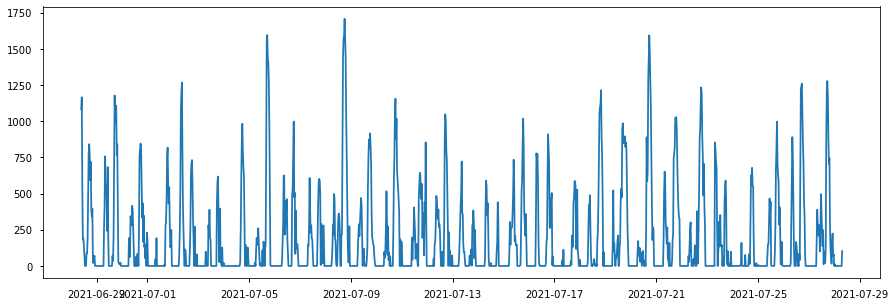

In [21]:
plt.figure(figsize=(15,5))
plt.plot(dff['datetime'], dff['PS'])
plt.show()

In [22]:
#Drop unnecessary columns
#solar, biomass, wind, nuclear, PS, NPSHYD
dff['low_carbon'] = dff['SOLAR'] + dff['BIOMASS'] + dff['WIND'] + dff['NUCLEAR'] + dff['PS'] + dff['NPSHYD']
dff['high_carbon'] = dff['OIL'] + dff['CGST'] + dff['COAL'] + dff['OCGT'] + dff['OTHER'] + dff['INTFR'] + dff['INTIRL'] + dff['INTNED'] + dff['INTEW'] + dff['INTNEM'] + dff['INTELEC'] + dff['INTIFA2'] + dff['INTNSL']
df_main = dff[['low_carbon', 'high_carbon', 'datetime']]
df_main.head()

,low_carbon,high_carbon,datetime
0,11296.0000,22523.0000,2021-06-28 09:30:00+00:00
1,11502.0000,22686.0000,2021-06-28 10:00:00+00:00
2,11089.0000,23153.0000,2021-06-28 10:30:00+00:00
3,10887.0000,23195.0000,2021-06-28 11:00:00+00:00
4,10927.0000,23400.0000,2021-06-28 11:30:00+00:00


In [23]:
df_main.columns

Index(['low_carbon', 'high_carbon', 'datetime'], dtype='object')

In [24]:
#Create function to check for null values

#Original source https://github.com/flatiron-school/Online-DS-FT-022221-Cohort-Notes/blob/master/Phase_3/topic_30_ensemble_methods/topic_30_ensemble_methods-SG.ipynb

def check_nulls(df):
    missingno.matrix(df)
    plt.show()
    null_check = pd.DataFrame({
        '#null':df.isna().sum(),
        '%null':round(df.isna().sum()/len(df)*100,2)
    })
    return null_check

In [25]:
germany_df = df_main.copy()

In [26]:
germany_df

,low_carbon,high_carbon,datetime
0,11296.0000,22523.0000,2021-06-28 09:30:00+00:00
1,11502.0000,22686.0000,2021-06-28 10:00:00+00:00
2,11089.0000,23153.0000,2021-06-28 10:30:00+00:00
3,10887.0000,23195.0000,2021-06-28 11:00:00+00:00
4,10927.0000,23400.0000,2021-06-28 11:30:00+00:00
...,...,...,...
1432,11045.0000,11563.0000,2021-07-28 05:30:00+00:00
1433,11375.0000,12817.0000,2021-07-28 06:00:00+00:00
1434,11668.0000,15031.0000,2021-07-28 06:30:00+00:00
1435,12216.0000,16023.0000,2021-07-28 07:00:00+00:00


In [27]:
germany_df = germany_df.set_index('datetime')

In [28]:
#Double check index is in date time
germany_df.index

DatetimeIndex(['2021-06-28 09:30:00+00:00', '2021-06-28 10:00:00+00:00',
               '2021-06-28 10:30:00+00:00', '2021-06-28 11:00:00+00:00',
               '2021-06-28 11:30:00+00:00', '2021-06-28 12:00:00+00:00',
               '2021-06-28 12:30:00+00:00', '2021-06-28 13:00:00+00:00',
               '2021-06-28 13:30:00+00:00', '2021-06-28 14:00:00+00:00',
               ...
               '2021-07-28 03:00:00+00:00', '2021-07-28 03:30:00+00:00',
               '2021-07-28 04:00:00+00:00', '2021-07-28 04:30:00+00:00',
               '2021-07-28 05:00:00+00:00', '2021-07-28 05:30:00+00:00',
               '2021-07-28 06:00:00+00:00', '2021-07-28 06:30:00+00:00',
               '2021-07-28 07:00:00+00:00', '2021-07-28 07:30:00+00:00'],
              dtype='datetime64[ns, UTC]', name='datetime', length=1437, freq=None)

In [29]:
germany_df = germany_df.iloc[1:]
germany_df

,low_carbon,high_carbon
datetime,,
2021-06-28 10:00:00+00:00,11502.0000,22686.0000
2021-06-28 10:30:00+00:00,11089.0000,23153.0000
2021-06-28 11:00:00+00:00,10887.0000,23195.0000
2021-06-28 11:30:00+00:00,10927.0000,23400.0000
2021-06-28 12:00:00+00:00,11215.0000,23274.0000
...,...,...
2021-07-28 05:30:00+00:00,11045.0000,11563.0000
2021-07-28 06:00:00+00:00,11375.0000,12817.0000
2021-07-28 06:30:00+00:00,11668.0000,15031.0000


<AxesSubplot:xlabel='datetime'>

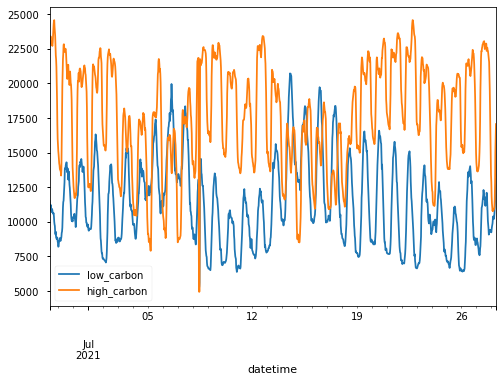

In [30]:
germany_df.plot()

In [31]:
germany_df['ratio'] = germany_df['low_carbon'] / germany_df['high_carbon']

<AxesSubplot:xlabel='datetime'>

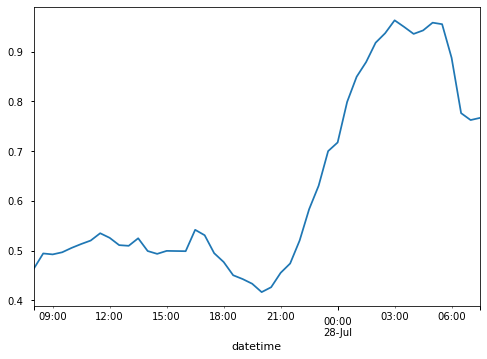

In [32]:
germany_df['ratio'].iloc[-48:].plot()

In [33]:
# Save cleaned dataset as CSV file
germany_df.to_csv('data/cleaned_energy_data.csv')

In [34]:
xxx

NameError: name 'xxx' is not defined

# Low carbon Modeling

<AxesSubplot:xlabel='datetime'>

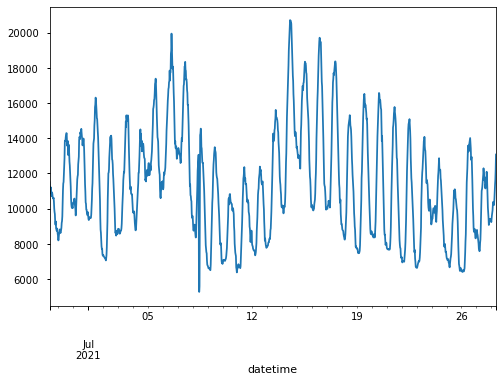

In [86]:
solar_ts = germany_df['low_carbon']
solar_ts.plot()

In [37]:
#Create function to create train test split
def train_test_split(ts):
    
    tts_cutoff = round(len(ts)*0.9)
    display(tts_cutoff)

    ## Use the tts cutoff to do Train test split and plot
    train = ts.iloc[:tts_cutoff]
    test = ts.iloc[tts_cutoff:]
    
    return train, test

In [38]:
solar_ts

datetime
2021-06-28 10:00:00+00:00   11502.0000
2021-06-28 10:30:00+00:00   11089.0000
2021-06-28 11:00:00+00:00   10887.0000
2021-06-28 11:30:00+00:00   10927.0000
2021-06-28 12:00:00+00:00   11215.0000
                               ...    
2021-07-28 05:30:00+00:00   11045.0000
2021-07-28 06:00:00+00:00   11375.0000
2021-07-28 06:30:00+00:00   11668.0000
2021-07-28 07:00:00+00:00   12216.0000
2021-07-28 07:30:00+00:00   13076.0000
Name: low_carbon, Length: 1436, dtype: float64

In [39]:
train, test = train_test_split(solar_ts)

1292

In [40]:
train

datetime
2021-06-28 10:00:00+00:00   11502.0000
2021-06-28 10:30:00+00:00   11089.0000
2021-06-28 11:00:00+00:00   10887.0000
2021-06-28 11:30:00+00:00   10927.0000
2021-06-28 12:00:00+00:00   11215.0000
                               ...    
2021-07-25 05:30:00+00:00    6852.0000
2021-07-25 06:00:00+00:00    6982.0000
2021-07-25 06:30:00+00:00    7184.0000
2021-07-25 07:00:00+00:00    7267.0000
2021-07-25 07:30:00+00:00    7423.0000
Name: low_carbon, Length: 1292, dtype: float64

In [41]:
#Create function to plot train test split for the time series
def plot_train_test_split(train, test):
    
    ## Plot
    ax = train.plot(label='train')
    test.plot(label='test')
    ax.legend()
    
    return ax

<AxesSubplot:xlabel='datetime'>

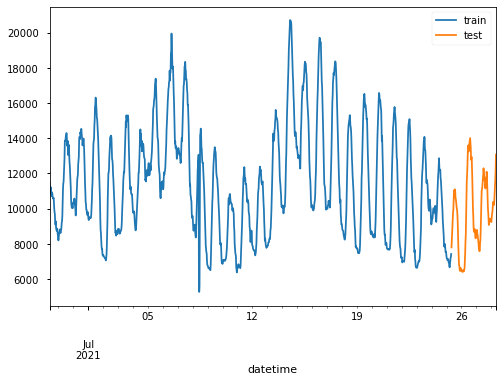

In [42]:
plot_train_test_split(train, test)

In [43]:
#Create Dickey Fuller Test test function
def adfuller_test_df(ts,index=['AD Fuller Results']):
    
    """Adapted from https://github.com/flatiron-school/Online-DS-FT-022221-Cohort-Notes/blob/master/Phase_4/topic_38_time_series_models/ts_functions.py
    Returns the AD Fuller Test Results and p-values for the null hypothesis
    that there the data is non-stationary (that there is a unit root in the data)"""
    
    df_res = tsa.stattools.adfuller(ts)

    names = ['Test Statistic','p-value','#Lags Used','# of Observations Used']
    res  = dict(zip(names,df_res[:4]))
    
    res['p<.05'] = res['p-value']<.05
    res['Stationary?'] = res['p<.05']
    
    if isinstance(index,str):
        index = [index]
    res_df = pd.DataFrame(res,index=index)
    res_df = res_df[['Test Statistic','#Lags Used',
                     '# of Observations Used','p-value','p<.05',
                    'Stationary?']]
    return res_df

In [44]:
#Create Stationarity evaluation function
def stationarity_check(TS,window=4,plot=True,index=['AD Fuller Results']):
    """Adapted from https://github.com/learn-co-curriculum/dsc-removing-trends-lab/tree/solution"""
    
    # Calculate rolling statistics
    roll_mean = TS.rolling(window=window, center=False).mean()
    roll_std = TS.rolling(window=window, center=False).std()
    
    # Perform the Dickey Fuller Test
    dftest = adfuller_test_df(TS,index=index)
    
    if plot:
        
        ## Building in contingency if not a series with a freq
        try: 
            freq = TS.index.freq
        except:
            freq = 'N/A'
            
        # Plot rolling statistics:
        fig = plt.figure(figsize=(12,6))
        plt.plot(TS, color='blue',label=f'Original (freq={freq}')
        plt.plot(roll_mean, color='red', label=f'Rolling Mean (window={window})')
        plt.plot(roll_std, color='black', label = f'Rolling Std (window={window})')
        plt.legend(loc='best')
        plt.title('Rolling Mean & Standard Deviation')
        display(dftest)
        plt.show(block=False)
        
    return dftest

In [45]:
test

datetime
2021-07-25 08:00:00+00:00    7800.0000
2021-07-25 08:30:00+00:00    8198.0000
2021-07-25 09:00:00+00:00    8581.0000
2021-07-25 09:30:00+00:00    9127.0000
2021-07-25 10:00:00+00:00    9410.0000
                               ...    
2021-07-28 05:30:00+00:00   11045.0000
2021-07-28 06:00:00+00:00   11375.0000
2021-07-28 06:30:00+00:00   11668.0000
2021-07-28 07:00:00+00:00   12216.0000
2021-07-28 07:30:00+00:00   13076.0000
Name: low_carbon, Length: 144, dtype: float64

,Test Statistic,#Lags Used,# of Observations Used,p-value,p<.05,Stationary?
AD Fuller Results,-4.2074,23,1268,0.0006,True,True


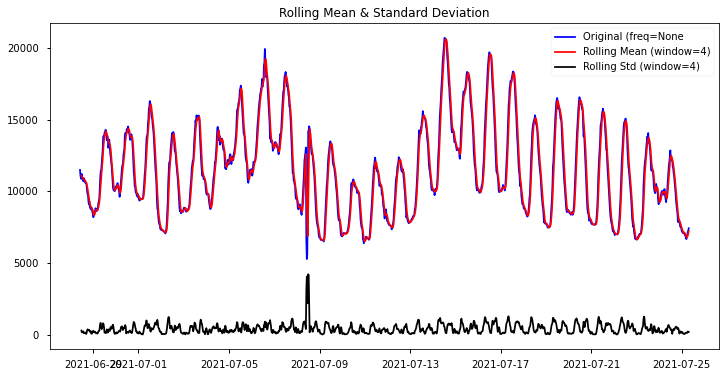

,Test Statistic,#Lags Used,# of Observations Used,p-value,p<.05,Stationary?
AD Fuller Results,-4.2074,23,1268,0.0006,True,True


In [46]:
#Check time series for stationarity
stationarity_check(train)

From the low p value, we can determine that the time series is stationary

In [47]:
#Create seasonal decomposition of time series to check for seasonality
decompose = tsa.seasonal_decompose(train)
decompose.plot()

ValueError: freq T not understood. Please report if you think this is in error.

### Sktime

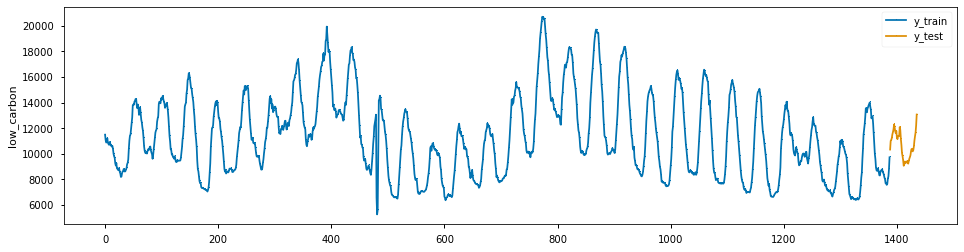

In [87]:
y = solar_ts.reset_index(drop=True)

y_train, y_test = temporal_train_test_split(y, test_size=48)
forecast_horizon = np.arange(y_test.shape[0]) + 1

plot_series(y_train, y_test, labels=["y_train", "y_test"], markers=[",", ","])
plt.show()

In [49]:
np.arange(y_test.shape[0])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47])

0.0926845889354343

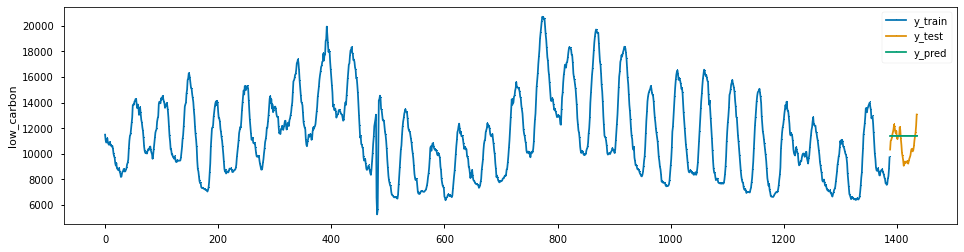

In [50]:
forecaster = NaiveForecaster(strategy="mean")
forecaster.fit(y_train)
y_pred = forecaster.predict(forecast_horizon)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"], markers=[",", ",", ","])
smape = mean_absolute_percentage_error(y_test, y_pred)
smape

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='low_carbon'>)

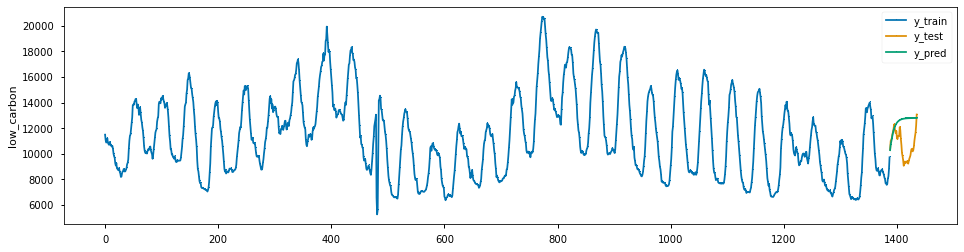

In [51]:
forecaster = AutoARIMA(suppress_warnings=True)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh=forecast_horizon)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"], markers=[",", ",", ","])


(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='low_carbon'>)

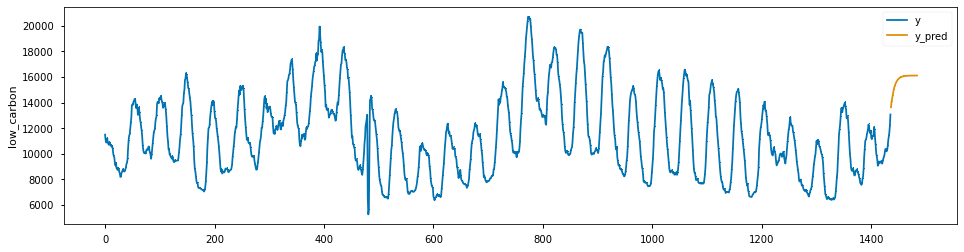

In [52]:
forecaster = AutoARIMA(suppress_warnings=True)
forecaster.fit(y)
y_pred = forecaster.predict(fh=forecast_horizon)
plot_series(y, y_pred, labels=["y", "y_pred"], markers=[",", ","])

0.13954881756618898

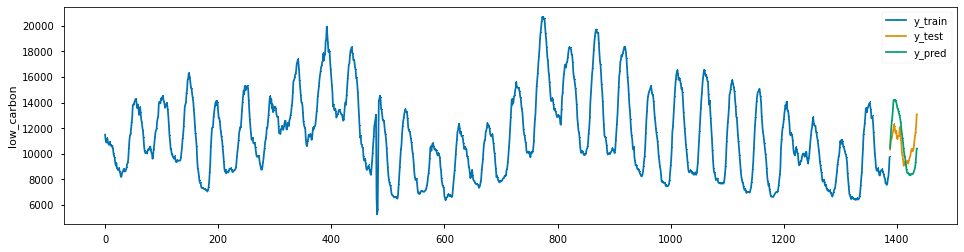

In [53]:
estimator = RandomForestRegressor()
forecaster = DirRecTabularRegressionForecaster(estimator=estimator)
forecaster.fit(y_train, fh=forecast_horizon)
y_pred = forecaster.predict(forecast_horizon)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"], markers=[",", ",", ","])
smape = mean_absolute_percentage_error(y_test, y_pred)
smape

0.11618204178621734

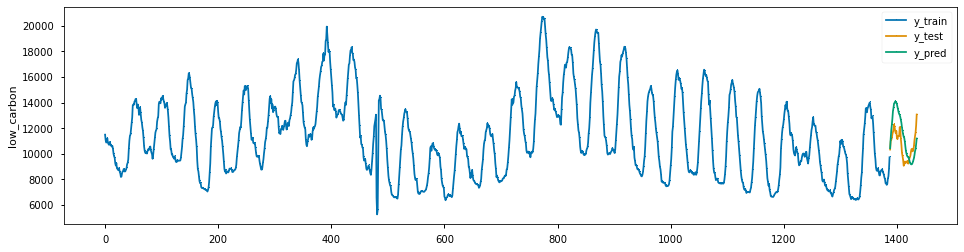

In [54]:
estimator = RandomForestRegressor()
forecaster = DirRecTabularRegressionForecaster(estimator=estimator)
param_grid = {"window_length": [1, 3, 5, 7]}

cv = SlidingWindowSplitter()
gscv = ForecastingGridSearchCV(forecaster, cv=cv, param_grid=param_grid)
gscv.fit(y_train, fh=forecast_horizon)
y_pred = gscv.predict(forecast_horizon)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"], markers=[",", ",", ","])
smape = mean_absolute_percentage_error(y_test, y_pred)
smape

In [55]:
gscv.best_params_

{'window_length': 7}

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='low_carbon'>)

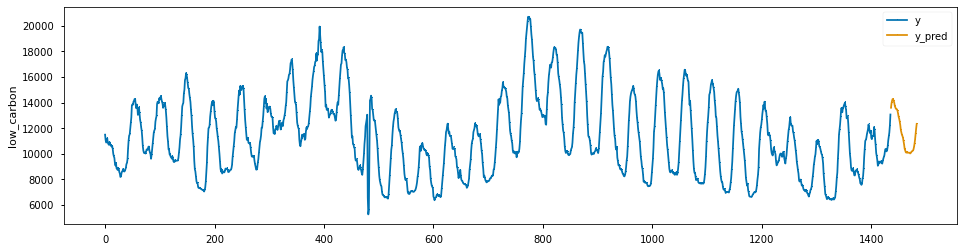

In [88]:
estimator = RandomForestRegressor()
forecaster = DirRecTabularRegressionForecaster(estimator=estimator, window_length=7)
forecaster.fit(y, fh=forecast_horizon)
y_pred = forecaster.predict(forecast_horizon)

plot_series(y, y_pred, labels=["y", "y_pred"], markers=[",", ","])

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='low_carbon'>)

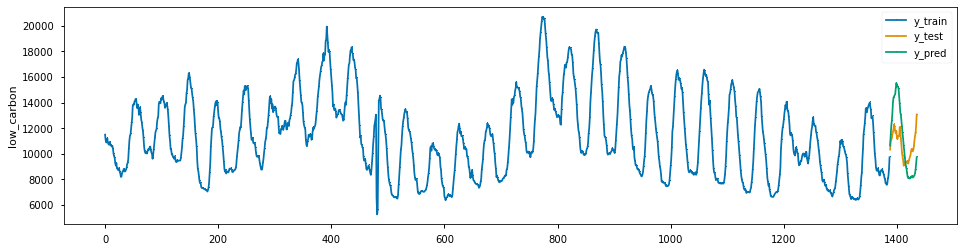

In [57]:
from xgboost import XGBRegressor
estimator = XGBRegressor()
forecaster = DirRecTabularRegressionForecaster(estimator=estimator, window_length=7)
forecaster.fit(y_train, fh=forecast_horizon)
y_pred = forecaster.predict(forecast_horizon)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"], markers=[",", ",", ","])
smape = mean_absolute_percentage_error(y_test, y_pred)
smape

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='low_carbon'>)

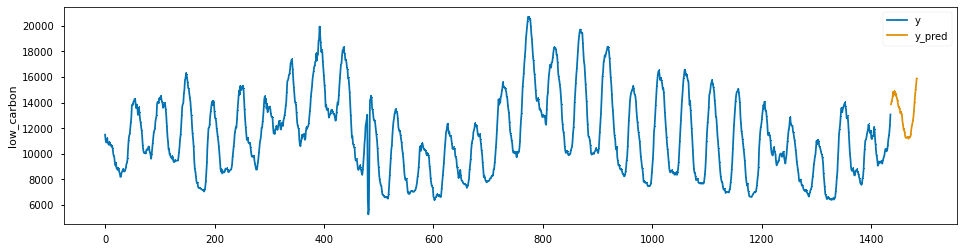

In [89]:

estimator = XGBRegressor()
forecaster = DirRecTabularRegressionForecaster(estimator=estimator, window_length=7)
forecaster.fit(y, fh=forecast_horizon)
y_pred = forecaster.predict(forecast_horizon)
y_lowcarbon = y_pred
plot_series(y, y_pred, labels=["y", "y_pred"], markers=[",", ","])

# High carbon Modeling

In [59]:
germany_df

,low_carbon,high_carbon,ratio
datetime,,,
2021-06-28 10:00:00+00:00,11502.0000,22686.0000,0.5070
2021-06-28 10:30:00+00:00,11089.0000,23153.0000,0.4789
2021-06-28 11:00:00+00:00,10887.0000,23195.0000,0.4694
2021-06-28 11:30:00+00:00,10927.0000,23400.0000,0.4670
2021-06-28 12:00:00+00:00,11215.0000,23274.0000,0.4819
...,...,...,...
2021-07-28 05:30:00+00:00,11045.0000,11563.0000,0.9552
2021-07-28 06:00:00+00:00,11375.0000,12817.0000,0.8875
2021-07-28 06:30:00+00:00,11668.0000,15031.0000,0.7763


<AxesSubplot:xlabel='datetime'>

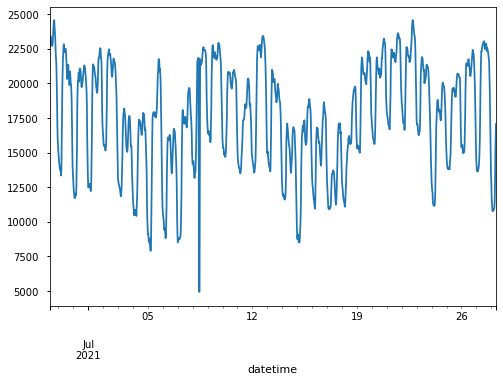

In [90]:
wind_ts = germany_df['high_carbon']
wind_ts.plot()

In [61]:
train, test = train_test_split(wind_ts)
plot_train_test_split(train, test)

1292

,Test Statistic,#Lags Used,# of Observations Used,p-value,p<.05,Stationary?
AD Fuller Results,-5.8737,14,1277,0.0000,True,True


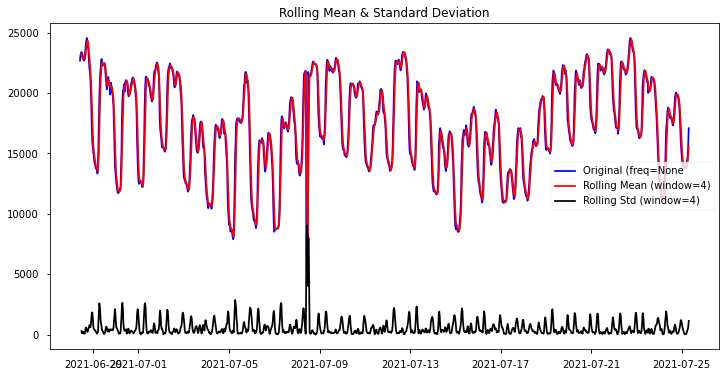

,Test Statistic,#Lags Used,# of Observations Used,p-value,p<.05,Stationary?
AD Fuller Results,-5.8737,14,1277,0.0000,True,True


In [63]:
#Check time series for stationarity
stationarity_check(train)

### Sktime

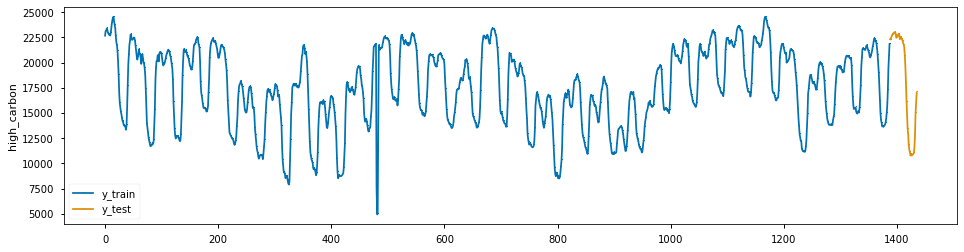

In [91]:
y = wind_ts.reset_index(drop=True)

y_train, y_test = temporal_train_test_split(y, test_size=48)
forecast_horizon = np.arange(y_test.shape[0]) + 1

plot_series(y_train, y_test, labels=["y_train", "y_test"], markers=[",", ","])
plt.show()

0.2801242044552497

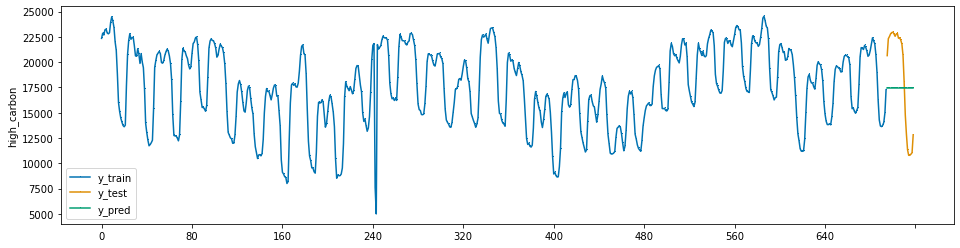

In [ ]:
forecaster = NaiveForecaster(strategy="mean")
forecaster.fit(y_train)
y_pred = forecaster.predict(forecast_horizon)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"], markers=[",", ",", ","])
smape = mean_absolute_percentage_error(y_test, y_pred)
smape

0.17869366274670848

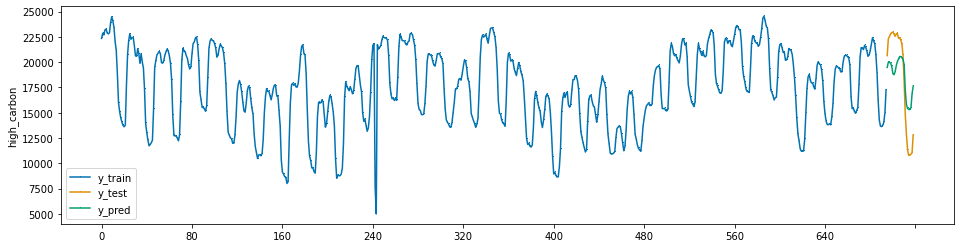

In [ ]:
estimator = RandomForestRegressor()
forecaster = DirRecTabularRegressionForecaster(estimator=estimator)
forecaster.fit(y_train, fh=forecast_horizon)
y_pred = forecaster.predict(forecast_horizon)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"], markers=[",", ",", ","])
smape = mean_absolute_percentage_error(y_test, y_pred)
smape

0.17860859025790657

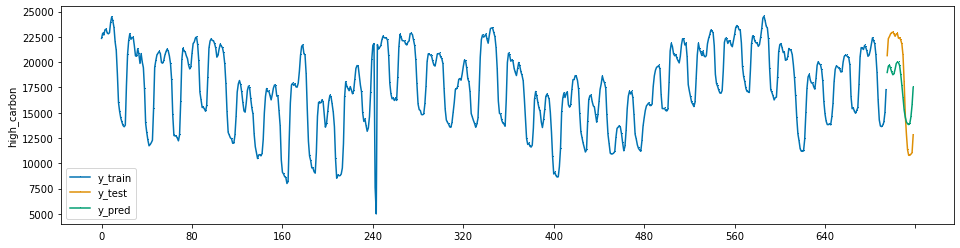

In [ ]:
estimator = RandomForestRegressor()
forecaster = DirRecTabularRegressionForecaster(estimator=estimator)
param_grid = {"window_length": [1, 3, 5, 7]}

cv = SlidingWindowSplitter()
gscv = ForecastingGridSearchCV(forecaster, cv=cv, param_grid=param_grid)
gscv.fit(y_train, fh=forecast_horizon)
y_pred = gscv.predict(forecast_horizon)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"], markers=[",", ",", ","])
smape = mean_absolute_percentage_error(y_test, y_pred)
smape

In [ ]:
gscv.best_params_

{'window_length': 7}

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='high_carbon'>)

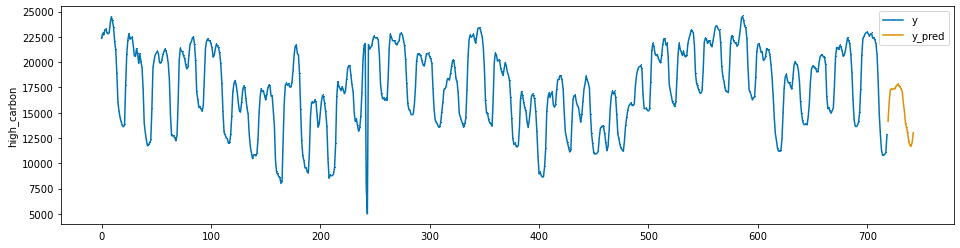

In [ ]:
estimator = RandomForestRegressor()
forecaster = DirRecTabularRegressionForecaster(estimator=estimator, window_length=7)
forecaster.fit(y, fh=forecast_horizon)
y_pred = forecaster.predict(forecast_horizon)

plot_series(y, y_pred, labels=["y", "y_pred"], markers=[",", ","])

0.25442872986727255

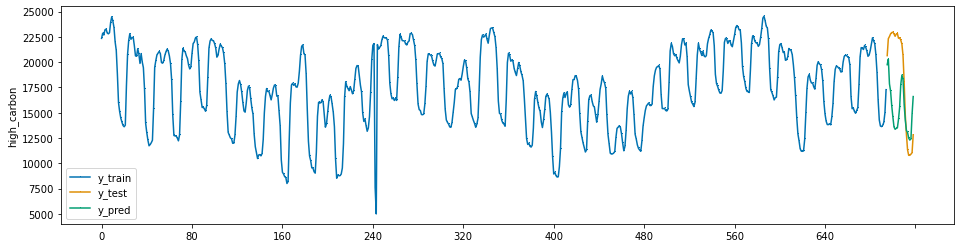

In [ ]:
from xgboost import XGBRegressor

estimator = XGBRegressor()
forecaster = DirRecTabularRegressionForecaster(estimator=estimator)
forecaster.fit(y_train, fh=forecast_horizon)
y_pred = forecaster.predict(forecast_horizon)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"], markers=[",", ",", ","])
smape = mean_absolute_percentage_error(y_test, y_pred)
smape

0.13418401019563017

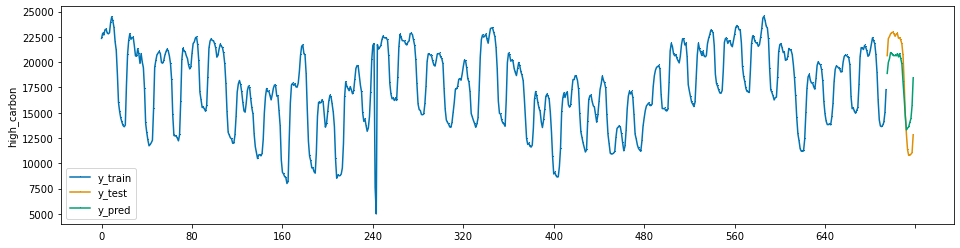

In [ ]:
estimator = XGBRegressor()
forecaster = DirRecTabularRegressionForecaster(estimator=estimator)
param_grid = {"window_length": [1, 5, 7]}

cv = SlidingWindowSplitter()
gscv = ForecastingGridSearchCV(forecaster, cv=cv, param_grid=param_grid)
gscv.fit(y_train, fh=forecast_horizon)
y_pred = gscv.predict(forecast_horizon)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"], markers=[",", ",", ","])
smape = mean_absolute_percentage_error(y_test, y_pred)
smape

In [ ]:
gscv.best_params_

{'window_length': 7}

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='high_carbon'>)

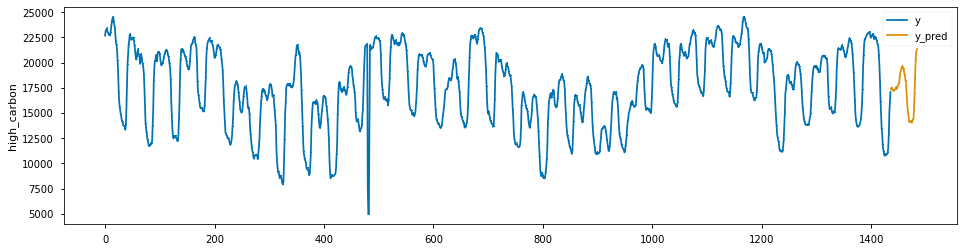

In [92]:
estimator = XGBRegressor()
forecaster = DirRecTabularRegressionForecaster(estimator=estimator, window_length=7)
forecaster.fit(y, fh=forecast_horizon)
y_pred = forecaster.predict(forecast_horizon)
y_highcarbon = y_pred
plot_series(y, y_pred, labels=["y", "y_pred"], markers=[",", ","])

# Ratio modeling

<AxesSubplot:xlabel='datetime'>

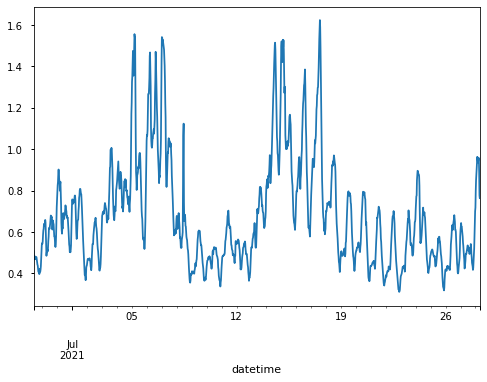

In [82]:
ratio = germany_df['ratio']
ratio.plot()

1292

<AxesSubplot:xlabel='datetime'>

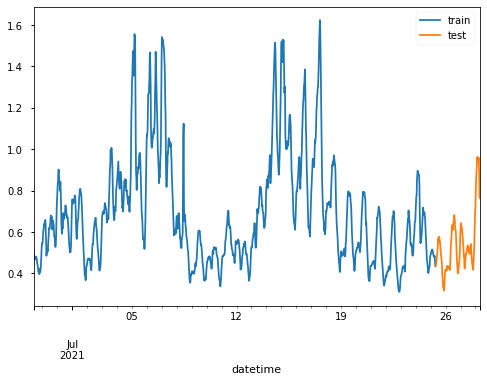

In [67]:
train, test = train_test_split(ratio)
plot_train_test_split(train, test)

,Test Statistic,#Lags Used,# of Observations Used,p-value,p<.05,Stationary?
AD Fuller Results,-3.7341,20,1271,0.0037,True,True


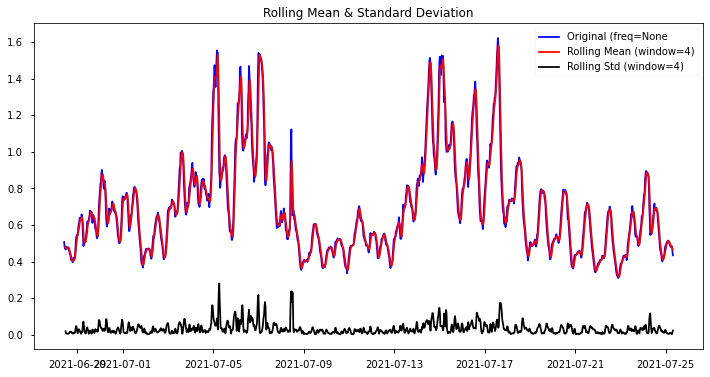

,Test Statistic,#Lags Used,# of Observations Used,p-value,p<.05,Stationary?
AD Fuller Results,-3.7341,20,1271,0.0037,True,True


In [68]:
stationarity_check(train)

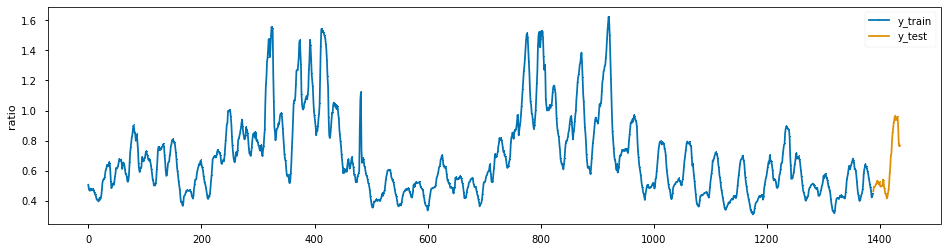

0.18912689604606095

In [83]:
y = ratio.reset_index(drop=True)

y_train, y_test = temporal_train_test_split(y, test_size=48)
forecast_horizon = np.arange(y_test.shape[0]) + 1

plot_series(y_train, y_test, labels=["y_train", "y_test"], markers=[",", ","])
plt.show()
smape = mean_absolute_percentage_error(y_test, y_pred)
smape

0.1450285340727583

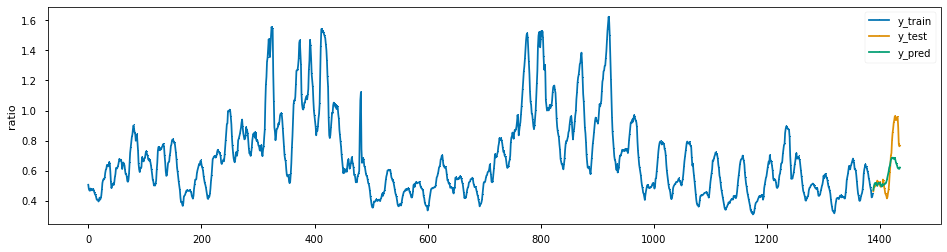

In [71]:
estimator = XGBRegressor()
forecaster = DirRecTabularRegressionForecaster(estimator=estimator)
param_grid = {"window_length": [1, 3, 5, 7]}

cv = SlidingWindowSplitter()
gscv = ForecastingGridSearchCV(forecaster, cv=cv, param_grid=param_grid)
gscv.fit(y_train, fh=forecast_horizon)
y_pred = gscv.predict(forecast_horizon)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"], markers=[",", ",", ","])
smape = mean_absolute_percentage_error(y_test, y_pred)
smape

In [73]:
gscv.best_params_

{'window_length': 7}

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='ratio'>)

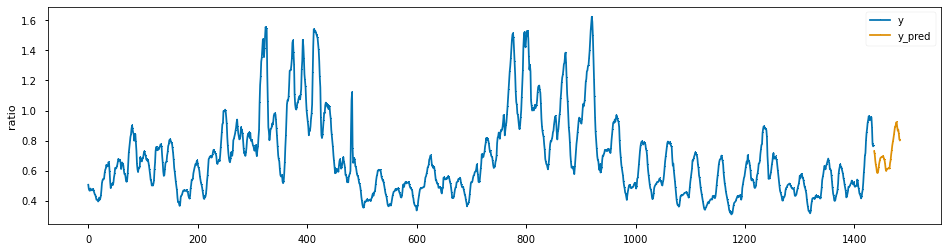

In [84]:
estimator = XGBRegressor()
forecaster = DirRecTabularRegressionForecaster(estimator=estimator, window_length=7)
forecaster.fit(y, fh=forecast_horizon)
y_pred = forecaster.predict(forecast_horizon)
y_ratio = y_pred
plot_series(y, y_pred, labels=["y", "y_pred"], markers=[",", ","])

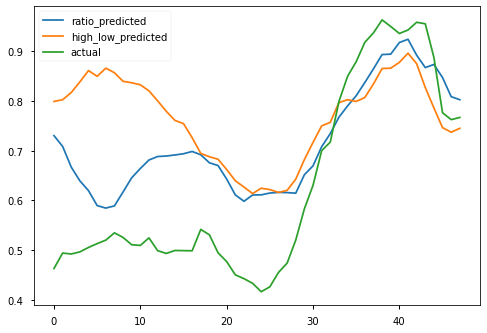

In [102]:
plt.plot(np.array(y_ratio), label = 'ratio_predicted')
plt.plot(np.array(y_lowcarbon/y_highcarbon), label = 'high_low_predicted')
plt.plot(np.array(germany_df['ratio'].iloc[-48:].reset_index(drop=True)), label = 'actual')
plt.legend()